In [5]:
import pickle
import numpy as np

In [6]:
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [36]:
# generate QA pairs
what_pokemon = ["What pokemon is there in the image",
                "What kind of pokemon is there in the picture",
                "What pokemon can you see in the image",
                "Can you tell what pokemon you see in this picture"]

what_attack = ["What attack is being performed by the pokemon",
               "The pokemon is performing which attack",
               "What kind of attack is in the picture",
               "What sort of attack is there in this image",
               "Can you tell what attack you see in this picture"]

what_type = ["What type of pokemon is it",
             "The image contains what type of pokemon",
             "Can you identify the type of pokemon",
             "What type of pokemon can you see in this picture"]

is_legendary = ["Is the pokemon legendary",
                "The pokemon in the image is legendary or not",
                "Does the picture contain a legendery pokemon",
                "Can you spot any powerful legendery pokemons here"]

what_color = ["What is the color of the pokemon in the image",
               "What color of pokemon can you spot in this picture",
               "What color of pokemon do you perceive in this image",
               "What shading or color can you see in the pokemon"]

all_questions = [what_pokemon, what_attack, what_type, is_legendary, what_color]

In [74]:
pairs_to_image_map = load_obj("battle_scenes_data/pairs_to_image_map")

In [75]:
pairs_to_image_map[355]

{'pokemon': 'Ditto', 'attack': 'transform', 'image_id': 10355}

In [76]:
pokemon_list = open("pokemon_attacks_classifier/Kanto.txt", "r").readlines()
name_to_id = dict()
for i, p in enumerate(pokemon_list):
    name_to_id[p.lower().strip()] = i+1

In [77]:
import pandas as pd
stats_df = pd.read_csv("pokemon_stats.csv")
poke_stats_map = dict()
for p in name_to_id:
    temp = dict()
    temp["name"] = stats_df.loc[[name_to_id[p]-1]]["Name"].to_string(index=False)
    temp["type"] = stats_df.loc[[name_to_id[p]-1]]["Type_1"].to_string(index=False)
    temp["legendary"] = stats_df.loc[[name_to_id[p]-1]]["isLegendary"].to_string(index=False) == "True"
    temp["color"] = stats_df.loc[[name_to_id[p]-1]]["Color"].to_string(index=False)
    poke_stats_map[p] = temp
print(poke_stats_map["mew"])

{'name': 'Mew', 'type': 'Psychic', 'legendary': False, 'color': 'Pink'}


In [92]:
qa_map_train = list()
qa_map_test = list()
for data in pairs_to_image_map:
    qid = -1
    wp = list(set(what_pokemon))
    for q in wp[:-1]:
        qid += 1
        qa_map_train.append({"question": q, "answer": data["pokemon"].lower(), "image_id": data["image_id"], "ques_id": qid})
    for q in wp[-1:]:
        qid += 1
        qa_map_test.append({"question": q, "answer": data["pokemon"].lower(), "image_id": data["image_id"], "ques_id": qid})

    wa = list(set(what_attack))
    for q in wa[:-2]:
        qid += 1
        qa_map_train.append({"question": q, "answer": data["attack"].lower(), "image_id": data["image_id"], "ques_id": qid})
    for q in wa[-2:]:
        qid += 1
        qa_map_test.append({"question": q, "answer": data["attack"].lower(), "image_id": data["image_id"], "ques_id": qid})
    
    wt = list(set(what_type))
    for q in wt[:-1]:
        qid += 1
        qa_map_train.append({"question": q, "answer": poke_stats_map[data["pokemon"].lower()]["type"], "image_id": data["image_id"], "ques_id": qid})
    for q in wt[-1:]:
        qid += 1
        qa_map_test.append({"question": q, "answer": poke_stats_map[data["pokemon"].lower()]["type"], "image_id": data["image_id"], "ques_id": qid})

    il = list(set(is_legendary))
    for q in il[:-1]:
        qid += 1
        qa_map_train.append({"question": q, "answer": poke_stats_map[data["pokemon"].lower()]["legendary"], "image_id": data["image_id"], "ques_id": qid})
    for q in il[-1:]:
        qid += 1
        qa_map_test.append({"question": q, "answer": poke_stats_map[data["pokemon"].lower()]["legendary"], "image_id": data["image_id"], "ques_id": qid})

    wc = list(set(what_colour))
    for q in wc[:-1]:
        qid += 1
        qa_map_train.append({"question": q, "answer": poke_stats_map[data["pokemon"].lower()]["color"], "image_id": data["image_id"], "ques_id": qid})
    for q in wc[-1:]:
        qid += 1
        qa_map_test.append({"question": q, "answer": poke_stats_map[data["pokemon"].lower()]["color"], "image_id": data["image_id"], "ques_id": qid})

In [93]:
[q for q in qa_map_train if q["image_id"] == 10355]
[q for q in qa_map_test if q["image_id"] == 10355]

[{'question': 'Can you tell what pokemon you see in this picture',
  'answer': 'ditto',
  'image_id': 10355,
  'ques_id': 3},
 {'question': 'What attack is being performed by the pokemon',
  'answer': 'transform',
  'image_id': 10355,
  'ques_id': 7},
 {'question': 'The pokemon is performing which attack',
  'answer': 'transform',
  'image_id': 10355,
  'ques_id': 8},
 {'question': 'The image contains what type of pokemon',
  'answer': 'Normal',
  'image_id': 10355,
  'ques_id': 12},
 {'question': 'Is the pokemon legendary',
  'answer': False,
  'image_id': 10355,
  'ques_id': 16},
 {'question': 'What color of pokemon can you spot in this picture',
  'answer': 'Purple',
  'image_id': 10355,
  'ques_id': 20}]

In [94]:
# vqa_raw_train.json and vqa_raw_test.json
# Format:
# {
#     "ques_id": image_id + qid,
#     "img_path": path/image_id.jpg,
#     "question": "",
#     "MC_ans": [ans],
#     "ans": ""
# }

In [95]:
vqa_raw_train = list()
vqa_raw_test = list()

for q_data in qa_map_train:
    temp = dict()
    temp["ques_id"] = int(str(q_data["image_id"]) + str(q_data["ques_id"]))
    temp["img_path"] = "battle_scenes/" + str(q_data["image_id"]) + ".jpg"
    temp["question"] = q_data["question"]
    temp["MC_ans"] = [q_data["answer"]]*5
    temp["ans"] = q_data["answer"]
    vqa_raw_train.append(temp)

for q_data in qa_map_test:
    temp = dict()
    temp["ques_id"] = int(str(q_data["image_id"]) + str(q_data["ques_id"]))
    temp["img_path"] = "battle_scenes/" + str(q_data["image_id"]) + ".jpg"
    temp["question"] = q_data["question"]
    temp["MC_ans"] = [q_data["answer"]]*5
    temp["ans"] = q_data["answer"]
    vqa_raw_test.append(temp)

In [96]:
print(vqa_raw_test[0])

{'ques_id': 100003, 'img_path': 'battle_scenes/10000.jpg', 'question': 'Can you tell what pokemon you see in this picture', 'MC_ans': ['parasect', 'parasect', 'parasect', 'parasect', 'parasect'], 'ans': 'parasect'}


In [97]:
# total classes/ans in our system
a = set([i["ans"]for i in vqa_raw_test])
b = set([i["ans"]for i in vqa_raw_train])
print(len(set(a.union(b))))

304


In [98]:
import json
with open('data/vqa_raw_train.json', 'w') as outfile:
    json.dump(vqa_raw_train, outfile)

with open('data/vqa_raw_test.json', 'w') as outfile:
    json.dump(vqa_raw_test, outfile)

In [89]:
# params.json OR use neural-vqa-attention/prepro.py
# python prepro.py --input_train_json vqa_raw_train.json --input_test_json vqa_raw_test.json --num_ans 304
# params = dict()
# params["unique_img_train"] = list()
# for d in vqa_raw_train:
#     params["unique_img_train"].append(d["img_path"])
# params["unique_img_test"] = list()
# for d in vqa_raw_train:
#     params["unique_img_test"].append(d["img_path"])

# with open('data/params.json', 'w') as outfile:
#     json.dump(params, outfile)

In [100]:
# questions and validation
# annotations.json
data = dict()
data["annotations"] = list()
for qa in (vqa_raw_train + vqa_raw_test):
    data["annotations"].append({"multiple_choice_answer": qa["ans"], "question_id": qa["ques_id"], "image_id": qa["img_path"]})
with open('data/annotations.json', 'w') as outfile:
    json.dump(data, outfile)

# questions.json
data = dict()
data["questions"] = list()
for qa in (vqa_raw_train + vqa_raw_test):
    data["questions"].append({"question": qa["question"], "question_id": qa["ques_id"], "image_id": qa["img_path"]})
with open('data/questions.json', 'w') as outfile:
    json.dump(data, outfile)

In [119]:
results = json.load(open("results/results_best.json", "r"))
qa_map = dict()
for i in vqa_raw_test:
    qa_map[i["ques_id"]] = i

c = 0
for result in results:
    if qa_map[result["question_id"]]["ans"] == result["answer"]:
        c+=1
print((c/len(results))*100)

65.90558129274211


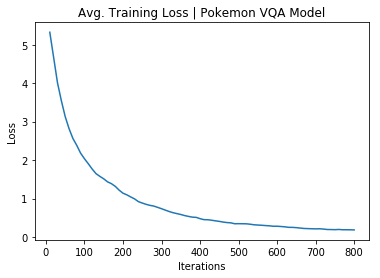

In [17]:
import matplotlib.pyplot as plt
values = [[float(i) for i in line.split()] for line in open("results/train.log").readlines()][1:]
[iter, epoch, loss] = list(zip(*values))
plt.plot(iter[:80], loss[:80])
plt.title("Avg. Training Loss | Pokemon VQA Model")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

In [125]:
# For generating img_train.h5 and img_test.h5
# Steps
# instance creation - get gpus
# after that run the instance and install the nvidia driver
# pull the docker and run it, install luarocks and loadcaffe after which you will be able to generate the image features
# once you get the image features, put them in the same directlry as the preprocessed sata obtained from prepro.py 
# install rnn from luarocks
# run the training after setting the batch size, iterations and checkpoints

In [126]:
# 0. /opt/deeplearning/install-driver.sh
# 1. nvidia-docker run -it --rm --name lua-env -v /home/jupyter:/root chaneyk/torch-cuda9:latest-gpu /bin/bash
# 2. apt-get install libprotobuf-dev protobuf-compiler
# 3. luarocks install loadcaffe (rnn in case of rnn)
# 4. th prepro_img.lua -input_json params.json -image_root ./ -gpuid 0

In [121]:
# sh scripts/download_vgg19.sh

In [122]:
# th prepro_img.lua -image_root /path/to/coco/images/ -gpuid 0

In [123]:
# th train.lua

In [124]:
# model_path=checkpoints/<time_stamp>/iter_800.t7 qa_h5=data/qa.h5 params_json=data/params.json img_test_h5=data/img_test.h5 th eval.lua